In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

# 事後予測

予測と観測されたデータが合致しない場合には、モデルの設定が何かおかしいと思うべき。

モデルの適切さをチェックする。

## 問題設定

- 二項分布に従う2標本データ
- 同一のパラメータを持つ二項分布からサンプルされたものと仮定してモデルを立てる
  - 3-3のモデルと同じ

## データ

極端に偏ったデータ。このデータだけ見ても共通のパラメータの分布からサンプルされたとは考えにくい。

In [3]:
ns = [10, 10]
ks = [0, 10]

## 推論(PyMC)

### モデル定義

In [4]:
with pm.Model() as model:
    theta = pm.Beta('theta', 1, 1)

    for i, (n, k) in enumerate(zip(ns, ks)):
        y = pm.Binomial(f'y_{i}', p=theta, n=n, observed=k)

### 推論

In [5]:
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

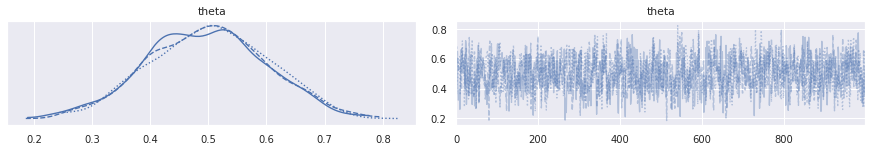

In [6]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'theta'}>], dtype=object)

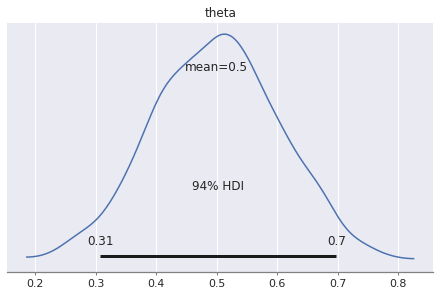

In [7]:
pm.plot_posterior(trace)

データは極度に偏っていたが、今回設定したモデルではその中間的な値で推論がされた

### 事後予測結果とデータを確認

In [8]:
with model:
    sample_post = pm.sample_posterior_predictive(trace)

In [10]:
import pandas as pd

In [18]:
ct = pd.crosstab(sample_post['y_0'], sample_post['y_1'], 
                 rownames=['y_0'], colnames=['y_1'])

<AxesSubplot:xlabel='y_1', ylabel='y_0'>

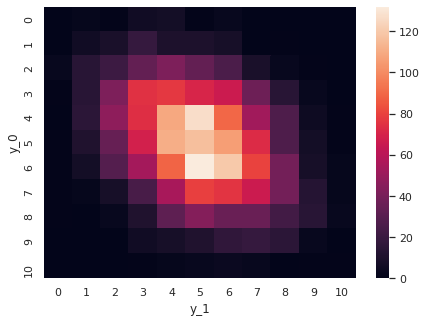

In [24]:
fig = plt.figure(figsize=(7,5))
ax = fig.subplots(1,1)

sns.heatmap(ct, ax=ax)

今回のデータは、kが[0, 10]なので、図の右上の端に位置する。

今回設計したモデルでは、その可能性はかなり低いものと予想されており、モデルとデータが合わない。二つの異なる分布として別々に推論するひつようがあると思われる。

## 推論（Pyro）

### モデル定義

In [26]:
def model_binom(params=None):
    theta = pyro.sample('theta', dist.Beta(torch.tensor(1.), torch.tensor(1.)))
    y = pyro.sample('y', dist.Binomial(total_count=n, probs=theta))
    return y

cond_model = pyro.condition(
    model_binom, 
    data={'y':torch.tensor(ks).float(), 
          'n':torch.tensor(ns).float()})

### 推論

In [48]:
nuts_kernel = infer.NUTS(cond_model, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=3000,
                  warmup_steps=500,
                  num_chains=1)

mcmc.run()

Sample: 100%|██████████| 3500/3500 [00:14, 242.25it/s, step size=9.45e-01, acc. prob=0.944]


### 推論結果の確認

In [49]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.50      0.11      0.50      0.32      0.67   1143.70      1.00

Number of divergences: 0


### 事後予測結果とデータを確認

In [50]:
cond_post = pyro.condition(
    model_binom, 
    data={'n':torch.tensor(10.), 
          'theta':mcmc.get_samples()['theta']})
post_sample1 = cond_post()
post_sample2 = cond_post()

In [51]:
ct = pd.crosstab(post_sample1.numpy(), post_sample2.numpy(), 
                 rownames=['y_0'], colnames=['y_1'])

<AxesSubplot:xlabel='y_1', ylabel='y_0'>

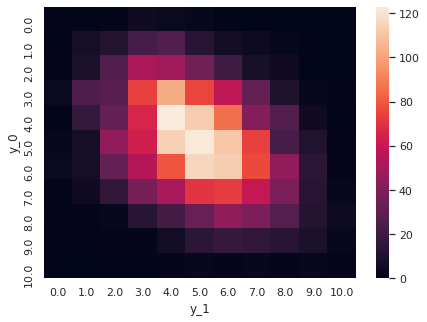

In [52]:
fig = plt.figure(figsize=(7,5))
ax = fig.subplots(1,1)

sns.heatmap(ct, ax=ax)